In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions


from pickle import load

Populating the interactive namespace from numpy and matplotlib


In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 C9 40 4C 40 5...|1951.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[E0 D4 30 D5 F0 D...|1952.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 4D 80 4D A0 5...|1953.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [4]:
# change pyspark sql dataframe to pandas dataframe
df_pd = df.toPandas()

In [151]:
#df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
#pdf=df2.toPandas()
#pdf.sort_values(by=['station'],inplace=True)
#pdf.head(2)
stations_idh = df_pd['station'].unique()
#stations_idh

# indicates there are 89 unique stations in the given area
# we can also use value_counts directly on pandas df
station_cnt = df.groupby(['station']).agg({"station": "count"})
station_cnt_df =station_cnt.toPandas().sort_values(by = ['count(station)'],ascending=False)
print station_cnt_df

        station  count(station)
53  USC00100010             488
56  USC00104670             478
49  USC00103297             477
38  USC00107673             473
4   USC00108380             465
28  USC00100227             463
16  USC00102676             405
63  USC00100915             396
83  USC00106877             382
59  USW00024156             366
15  USC00105980             343
18  USC00103942             330
88  USC00104456             318
58  USC00107040             311
35  USC00100375             299
42  USC00103882             294
21  USW00094143             282
84  USC00102260             276
44  USC00107968             273
13  USW00024145             269
87  USC00108937             265
68  USW00024142             239
47  USC00106764             234
9   USC00104455             229
69  USC00104845             219
41  USC00104588             207
36  USC00105716             201
19  USC00108626             199
65  USC00108906             194
22  USC00105678             186
..      

In [6]:
# identify lat and long 
lat = df_pd['latitude']
longi = df_pd['longitude']

lat_min = lat.min()
lat_max = lat.max()
print lat_min
print lat_max

longi_min = longi.min()
longi_max = longi.max()
print longi_min
print longi_max

42.6006
43.75
-114.75
-111.05


In [7]:
# picking the station with max data among all the stations
# 
station_PRCP_df = df_pd[(df_pd['measurement'] == 'PRCP') & (df_pd['station'] == 'USC00100010')]
#test1 = df_pd[(df_pd['measurement'] == 'PRCP')]
print station_PRCP_df.shape

station_Tmin_df = df_pd[(df_pd['measurement'] == 'TMIN') & (df_pd['station'] == 'USC00100010')]
print station_Tmin_df.shape

station_Tmax_df = df_pd[(df_pd['measurement'] == 'TMAX') & (df_pd['station'] == 'USC00100010')]
print station_Tmax_df.shape

station_SNOW_df = df_pd[(df_pd['measurement'] == 'SNOW') & (df_pd['station'] == 'USC00100010')]
print station_SNOW_df.shape

station_SNWD_df = df_pd[(df_pd['measurement'] == 'SNWD') & (df_pd['station'] == 'USC00100010')]
print station_SNWD_df.shape

station_TOBS_df = df_pd[(df_pd['measurement'] == 'TOBS') & (df_pd['station'] == 'USC00100010')]
print station_TOBS_df.shape

(97, 9)
(97, 9)
(97, 9)
(77, 9)
(59, 9)
(61, 9)


In [8]:
# this is panda series with vector
station_PRCP_data = station_PRCP_df['vector']
station_PRCP_idx = station_PRCP_df['year']



In [9]:
station_PRCP_data

6017    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128...
6018    [0, 0, 0, 79, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
6019    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0, 66, 0...
6020    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 192, 81, ...
6021    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6022    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6023    [0, 69, 128, 79, 192, 81, 0, 0, 0, 0, 0, 0, 0,...
6024    [0, 0, 16, 88, 0, 77, 0, 73, 0, 69, 0, 0, 0, 0...
6025    [0, 0, 0, 0, 0, 0, 0, 66, 0, 72, 0, 0, 0, 0, 0...
6026    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6027    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 69, 0,...
6028    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6029    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96, 85, 0, 0, 0...
6030    [128, 74, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 0, 0,...
6031    [0, 0, 0, 0, 0, 0, 0, 0, 128, 79, 0, 0, 0, 0, ...
6032    [0, 0, 128, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6033    [0, 0, 0, 0, 0, 0, 0, 69, 0, 0, 0, 0, 0, 0, 0,...
6034    [0, 0,

In [90]:
# this query for a specific measurement and specific station
sqlContext.registerDataFrameAsTable(df,'weather')

# This station ID has to match one of the station ID that you have from above list
# changed query to limit year as well 
# Because there is lot of missing data restricted analysis to last 22 years from 1990
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s' and year > '%s'"%('PRCP','USC00100010', '1990' )
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)

rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
PRCP_stn1=np.vstack(rows)
PRCP_stn1=PRCP_stn1/10# scaling to make the temperature be in centingrates
shape(PRCP_stn1)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00100010' and year > '1990'
22 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1342.6| 42.9536|-112.8253|       PRCP|USC00100010|     0|[00 00 00 00 00 0...|1991.0|SBSSBBBS|
|   1342.6| 42.9536|-112.8253|       PRCP|USC00100010|     0|[00 00 00 00 00 0...|1992.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(22, 365)

In [91]:
# Data considered only for last 22 years
# SNOW_stn1 snow fall for that station USC00100010
# SNWD_stn1 snow depth for that station USC00100010

SNOW_stn1_df = pd.DataFrame(SNOW_stn1)
SNWD_stn1_df = pd.DataFrame(SNWD_stn1)
print SNOW_stn1_df.shape
print SNWD_stn1_df.shape

TMIN_stn1_df = pd.DataFrame(TMIN_stn1)
TMAX_stn1_df = pd.DataFrame(TMAX_stn1)
TOBS_stn1_df = pd.DataFrame(TOBS_stn1)
PRCP_stn1_df = pd.DataFrame(PRCP_stn1)
print TMIN_stn1_df.shape
print TOBS_stn1_df.shape
print TMAX_stn1_df.shape
print PRCP_stn1_df.shape


(22, 365)
(22, 365)
(22, 365)
(22, 365)
(22, 365)
(22, 365)


In [172]:
# this query for a specific measurement and specific station
sqlContext.registerDataFrameAsTable(df,'weather')

# This station ID has to match one of the station ID that you have from above list
# changed query to limit year as well 
# Because there is lot of missing data restricted analysis to last 22 years from 1990
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s' and year > '%s'"%('PRCP','USC00104456', '1961' )
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)

rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
PRCP_stn2=np.vstack(rows)
PRCP_stn2=PRCP_stn2/10  # scaling to make the temperature and precipitation be in centingrates and mm respectively
shape(PRCP_stn2)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00104456' and year > '1961'
50 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1776.4| 43.3456|-111.7847|       PRCP|USC00104456|     0|[00 00 00 00 00 0...|1962.0|SBSSBBBS|
|   1776.4| 43.3456|-111.7847|       PRCP|USC00104456|     0|[00 00 00 00 00 4...|1963.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(50, 365)

In [187]:
# this query for a specific measurement and specific station
sqlContext.registerDataFrameAsTable(df,'weather')

# This station ID has to match one of the station ID that you have from above list
# changed query to limit year as well 
# Because there is lot of missing data restricted analysis to last 22 years from 1990
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s' and year > '%s'"%('TMIN','USC00102260', '1962' )
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(42)

rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
PRCP_stn3=np.vstack(rows)
PRCP_stn3=PRCP_stn3/10  # scaling to make the temperature and precipitation be in centingrates and mm respectively
shape(PRCP_stn3)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00102260' and year > '1962'
41 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     6|[50 D7 00 D3 80 D...|1963.0|SBSSBBBS|
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     4|[A0 D7 00 D3 00 D...|1964.0|SBSSBBBS|
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     1|[F0 DA E8 D9 28 D...|1965.0|SBSSBBBS|
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     1|[E8 D9 E8 D9 90 D...|1966.0|SBSSBBBS|
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|     0|[50 D7 50 D7 A0 D...|1967.0|SBSSBBBS|
|   1797.4|  43.465|-113.5581|       TMIN|USC00102260|    32|[58 D8 58 D8 28 D...|1968.0|SBSSBBBS|
|   1797.

(41, 365)

In [173]:
# Data considered only for last 22 years
# SNOW_stn2 snow fall for that station USC00104456
# SNWD_stn2 snow depth for that station USC00104456

SNOW_stn2_df = pd.DataFrame(SNOW_stn2)
SNWD_stn2_df = pd.DataFrame(SNWD_stn2)
print SNOW_stn2_df.shape
print SNWD_stn2_df.shape

TMIN_stn2_df = pd.DataFrame(TMIN_stn2)
TMAX_stn2_df = pd.DataFrame(TMAX_stn2)
TOBS_stn2_df = pd.DataFrame(TOBS_stn2)
PRCP_stn2_df = pd.DataFrame(PRCP_stn2)
print TMIN_stn2_df.shape
print TOBS_stn2_df.shape
print TMAX_stn2_df.shape
print PRCP_stn2_df.shape

(50, 365)
(50, 365)
(50, 365)
(50, 365)
(50, 365)
(50, 365)


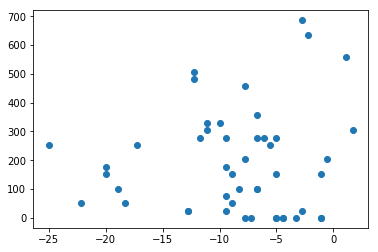

In [174]:
# Scatter plot to study correlation
plt.scatter(TMIN_stn2_df[:][60],SNWD_stn2_df[:][60])

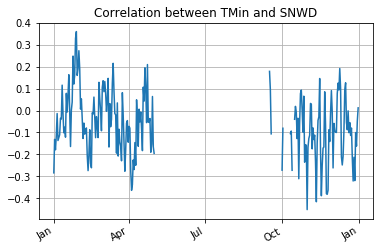

In [175]:
# Correlation for entire year 
# below output indicate that SNWD is correlated with TMIN
# During winters, it is highly positively correlated with TMIN meaning decrease in TMIN and increase in SNWD observed
# During spring, these two are negatively correlated as increase in TMIN, observed a drop in SNOWdepth
corr_list = []
for i in range(365):
    snwd_test2 = SNWD_stn2_df[:][i]
    tmin_test2 = TMIN_stn2_df[:][i]
    corr = snwd_test2.corr(tmin_test2)
    corr_list.append(corr)
    #print corr
    
#plt.plot(corr_list)
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()

YP.plot(corr_list,fig,ax,title='Correlation between TMin and SNWD')



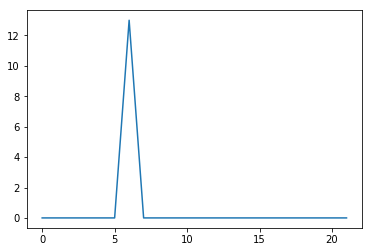

In [100]:
plt.plot(SNOW_stn1_df[:][60])


In [230]:
snwd_stn1_test2 = SNWD_stn1_df[1][:]
m1 = snwd_stn1_test2.mean(axis = 0)
m1
#plt.plot(snwd_stn1_test2.mean)

77.312

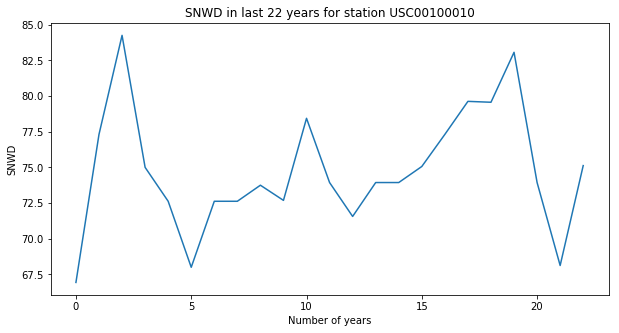

In [244]:
snwd_mean_stn1 = []
tmin_mean_stn1 = []
for i in range(23):
    snwd_stn1_test2  = SNWD_stn1_df[i][:]
    tmin_stn1_test2 = TMIN_stn1_df[i][:]
    m1 = snwd_stn1_test2.mean(axis=0)
    m2 = tmin_stn1_test2.mean(axis=0)
    snwd_mean_stn1.append(m1)
    tmin_mean_stn1.append(m2)

# Average TMIN and SNWD plots
fig, ax = plt.subplots(figsize=(10,5));
plt.plot(snwd_mean_stn1)
#plt.plot(tmin_mean_stn1)
plt.xlabel('Number of years')
plt.ylabel('SNWD')
plt.title('SNWD in last 22 years for station USC00100010')
plt.show()

In [235]:
type(snwd_mean_stn1)

list

In [236]:
np.mean(snwd_mean_stn1)

74.75

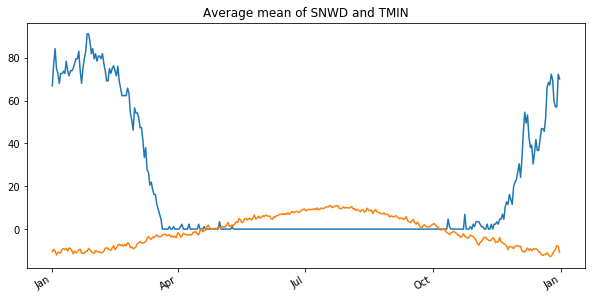

In [224]:
snwd_mean_stn1 = []
tmin_mean_stn1 = []
for i in range(365):
    snwd_stn1_test2  = SNWD_stn1_df[:][i]
    tmin_stn1_test2 = TMIN_stn1_df[:][i]
    m1 = snwd_stn1_test2.mean(axis=0)
    m2 = tmin_stn1_test2.mean(axis=0)
    snwd_mean_stn1.append(m1)
    tmin_mean_stn1.append(m2)
    
#plt.plot(corr_list)
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,5));
YP=YearPlotter()

YP.plot(snwd_mean_stn1,fig,ax,title='Average mean of SNWD and TMIN')
YP.plot(tmin_mean_stn1,fig,ax,title='Average mean of SNWD and TMIN')

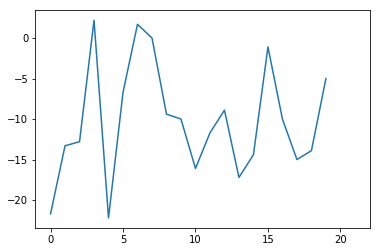

In [199]:
# Plot to understand that TMIN temperature if this is increasing over the last few years
plt.plot(TMIN_stn1_df[:][2])

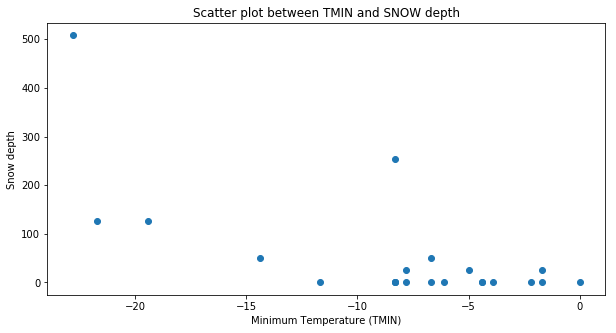

In [197]:
# Scatter plot to study correlation
fig, ax = plt.subplots(figsize=(10,5));
plt.scatter(TMIN_stn1_df[:][60],SNWD_stn1_df[:][60])
plt.xlabel('Minimum Temperature (TMIN)')
plt.ylabel('Snow depth')
plt.title('Scatter plot between TMIN and SNOW depth')
plt.show()

In [136]:
# correlation for a specific day for all 22 years
snwd_test1 = SNWD_stn1_df[:][60]
tmin_test1 = TMIN_stn1_df[:][60]
tmax_test1 = TMAX_stn1_df[:][60]
snow_test1 = SNOW_stn1_df[:][60]
print snwd_test1.corr(tmin_test1)

# Negative correlation between snow depth and tmin/tmax
# 

-0.670046244266


#### Below correlation study is used for explaining why SNWD analysis useful 

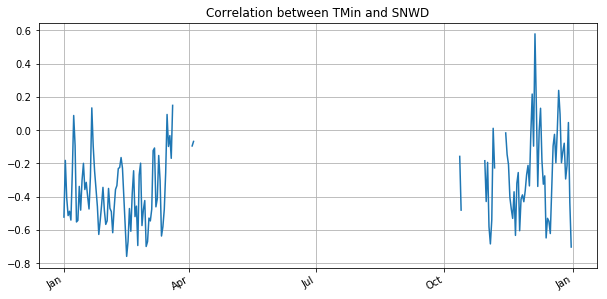

In [195]:
# Correlation for entire year 
# below output indicate that SNWD is correlated with TMIN
# During winters, it is highly positively correlated with TMIN meaning decrease in TMIN and increase in SNWD observed
# During spring, these two are negatively correlated as increase in TMIN, observed a drop in SNOWdepth
corr_list = []
for i in range(365):
    snwd_test1 = SNWD_stn1_df[:][i]
    tmin_test1 = TMIN_stn1_df[:][i]
    corr = snwd_test1.corr(tmin_test1)
    corr_list.append(corr)
    #print corr
    
#plt.plot(corr_list)
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,5));
YP=YearPlotter()

YP.plot(corr_list,fig,ax,title='Correlation between TMin and SNWD')


#### Below correlation study not much message... 

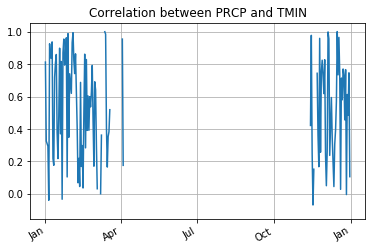

In [150]:
# Correlation for entire year 
# below output indicate that PRCP is correlated with SNWD
# During winters, it is highly positively correlated with TMIN meaning decrease in TMIN and increase in SNWD observed
# During spring, these two are negatively correlated as increase in TMIN, observed a drop in SNOWdepth
corr_list = []
for i in range(365):
    snow_test1 = SNOW_stn1_df[:][i]
    prcp_test1 = PRCP_stn1_df[:][i]
    corr = snow_test1.corr(prcp_test1)
    corr_list.append(corr)
    #print corr
    
#plt.plot(corr_list)
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()

YP.plot(corr_list,fig,ax,title='Correlation between PRCP and TMIN')

In [133]:
# correlation for a specific year and all 365 days
snwd_test1 = SNWD_stn1_df[20][:]
tmin_test1 = TMIN_stn1_df[20][:]
tmax_test1 = TMAX_stn1_df[20][:]
snow_test1 = SNOW_stn1_df[20][:]
print snwd_test1.corr(tmax_test1)

-0.056221571202


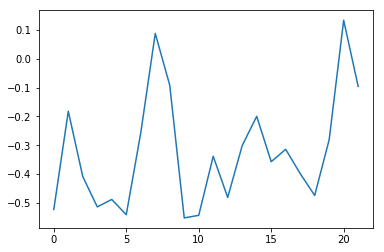

In [145]:
corr_list = []
for i in range(22):
    snwd_test1 = SNWD_stn1_df[i][:]
    tmin_test1 = TMIN_stn1_df[i][:]
    corr = snwd_test1.corr(tmin_test1)
    corr_list.append(corr)
    #print corr
    
plt.plot(corr_list)

In [113]:
TMIN_stn1_df.corrwith(TMIN_stn1_df.transpose)

AttributeError: 'function' object has no attribute '_get_numeric_data'

In [31]:
test_t1 = pd.rolling_mean(PRCP_df,5)
test_t1.shape

/Users/sumangunnala/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5,center=False).mean()
  if __name__ == '__main__':


(97, 365)

In [19]:
PRCP_stn1[1,:].shape

(365,)

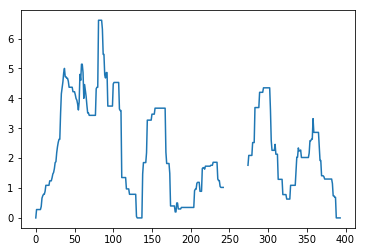

In [27]:
t1 = np.convolve(PRCP_stn1[1,:], np.ones(30)/10)
plt.plot(t1)

TypeError: float() argument must be a string or a number

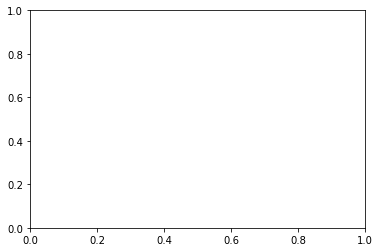

In [28]:
plt.plot(PRCP_stn1[1,:])

In [ ]:
# PRCP = Precipitation (tenths of mm)
# SNOW = Snowfall (mm)
# SNWD = Snow depth (mm)
# TMAX = Maximum temperature (tenths of degrees C)
# TMIN = Minimum temperature (tenths of degrees C)
# TOBS = Temperature at the time of observation (tenths of degrees C)

In [112]:
# This query is to extract data for each measurement for all station ID's in that region to 
sqlContext.registerDataFrameAsTable(df,'weather')

# This below query includes all station ID's and specific measurement parameter chosen
# Individual data frames are created and respective data is unpacked
# ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']

Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('PRCP')
print Query

df2 = sqlContext.sql(Query)
print df2.count(),'rows'
df2.show(2)

#df_PRCP = df2.toPandas()

# vector for that measurement is unpacked
rows_2=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T_2 = np.vstack(rows_2)

T_2=T_2/10.  # scaling to make the temperature/precipitation be in centingrade or mm respectively as they are in tenths of their respective units
shape(T_2)

SELECT * FROM weather
	WHERE measurement='PRCP'
2407 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       PRCP|USC00105980|     0|[40 4E 00 45 00 0...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       PRCP|USC00105980|     0|[00 00 00 49 00 0...|1950.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2407, 365)

(2606, 9)
(2606, 365)
(1866, 9)
(1866, 365)
(2603, 9)
(2603, 365)
(1769, 9)
(1769, 365)
(1125, 9)
(1125, 365)
(2407, 9)
(2407, 365)


12376

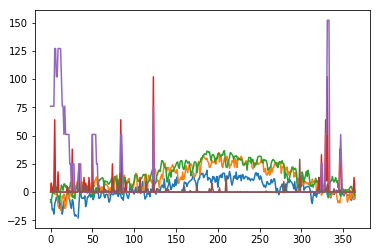

In [114]:
print df_TMIN.shape
print TMIN_all.shape

plt.plot(TMIN_all[1,:])

print df_TOBS.shape
print TOBS_all.shape

plt.plot(TOBS_all[1,:])

print df_TMAX.shape
print TMAX_all.shape

plt.plot(TMAX_all[26,:])

print df_SNOW.shape
print SNOW_all.shape

plt.plot(SNOW_all[26,:])

print df_SNWD.shape
print SNWD_all.shape

plt.plot(SNWD_all[26,:])

print df_PRCP.shape
print PRCP_all.shape

plt.plot(PRCP_all[26,:])

len(df_TOBS)+ len(df_TMIN)+len(df_TMAX)+len(df_SNOW)+len(df_SNWD)+len(df_PRCP)

In [120]:
#test1 = df_pd[(df_pd['measurement'] == 'SNWD') & (df_pd['station'] == 'USC00105980')]
test1 = df_pd[(df_pd['measurement'] == 'SNWD')]
len(test1)

1125

In [125]:
corr_coeff_t = np.corrcoef(TMIN_all,SNWD_all)
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [130]:
TMIN_SNWD.shape

(3731, 3731)

In [149]:
# Analysis for station1: USC00105980
print SNWD_st1.shape
print T_MIN_st1.shape


(49, 365)
(62, 365)


NameError: name 'SNWD_st1' is not defined

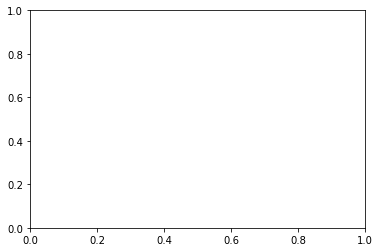

In [91]:

from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()

YP.plot(SNWD_st1[5].transpose(),fig,ax)
YP.plot(T_MIN_st1[5].transpose(),fig,ax)